In [2]:
%load_ext autoreload

%autoreload

In [1]:
import problem
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import yaml

from problem import *

In [2]:
with open('config_basic.yml', 'r') as file:
        c = yaml.safe_load(file)

In [3]:
# Create spatial discretisation 
lat_first = c['spatial_discretisation']['lat_first']
lat_final = c['spatial_discretisation']['lat_final']
lat_n     = c['spatial_discretisation']['lat_n']
lng_first = c['spatial_discretisation']['lng_first']
lng_final = c['spatial_discretisation']['lng_final']
lng_n     = c['spatial_discretisation']['lng_n']

lat,lng = jnp.mgrid[lat_first:lat_final:lat_n*1j,
                    lng_first:lng_final:lng_n*1j]

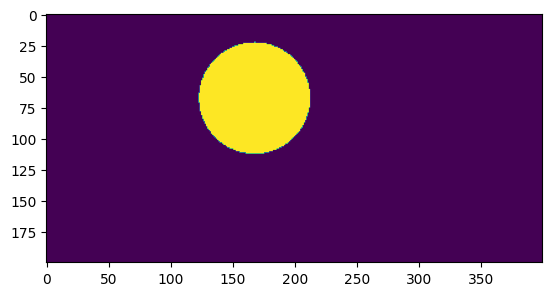

In [4]:
_, _, v = problem.ic_flow_v_only(lat,lng)
plt.imshow(v[0]+v[1])

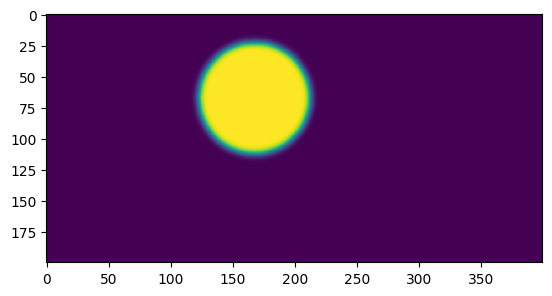

In [23]:
# BLUR V
v += (jnp.roll(v, 1,axis=-1)
     +jnp.roll(v,-1,axis=-1)
     +jnp.roll(v, 1,axis=-2)
     +jnp.roll(v,-1,axis=-2))
v/=5
plt.imshow(v[0])

In [24]:
def gradient(y):
    return jnp.array( (ptheta(y), plambda(y)))

-13.971676 13.970464


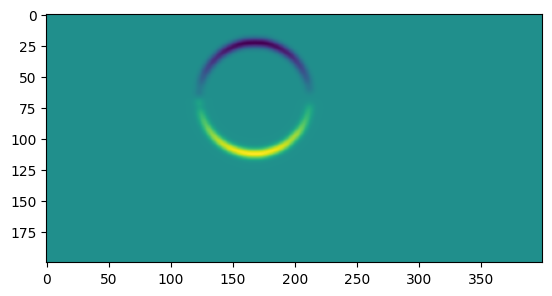

In [91]:
rhs = -divergence(v)
plt.imshow(-rhs)
print(jnp.amin(rhs), jnp.amax(rhs))

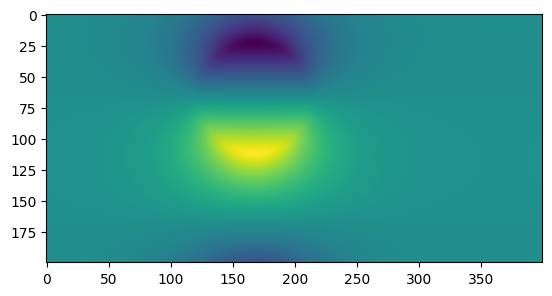

In [74]:
import jax.scipy as jsp
q, _ = jsp.sparse.linalg.cg(laplacian, rhs , maxiter= 10000)
plt.imshow( q)

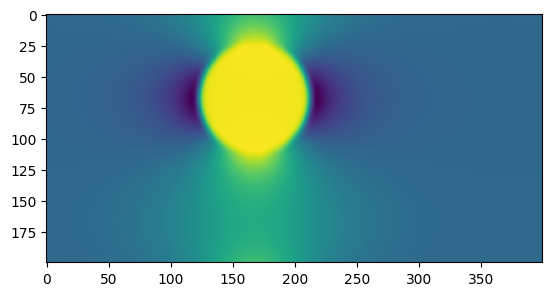

In [75]:
v_f = v +gradient(q)
plt.imshow(v_f[0])
#plt.imshow(v_f[1])

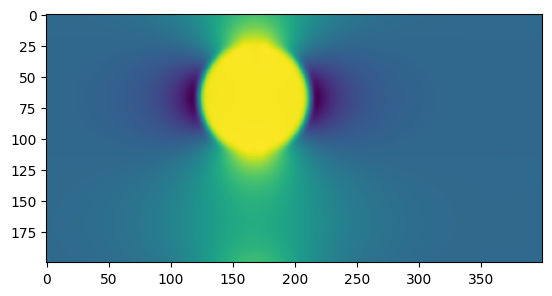

In [89]:

q, _ = jsp.sparse.linalg.cg(laplacian, -divergence( v_f ), maxiter= 100)
v_f = v_f + gradient(q)
plt.imshow(v_f[0])

-0.00042700022 0.0004659891


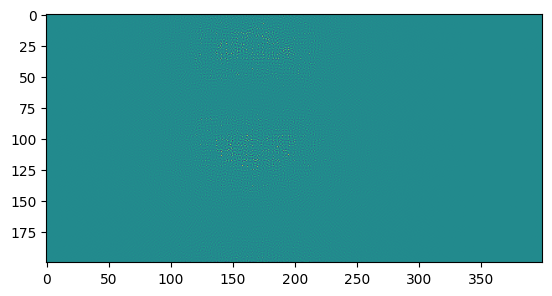

In [90]:
div = divergence(v_f)
plt.imshow(div)
print(jnp.amin(div), jnp.amax(div))

-13.971676 13.971398


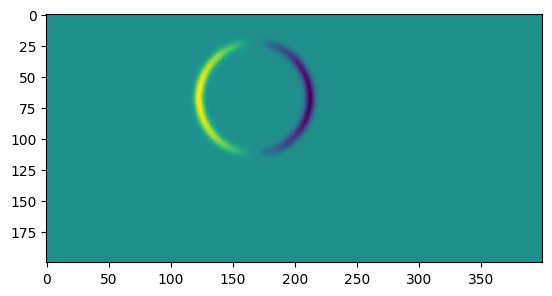

In [52]:
def curl(v):
    return ptheta(v[1]) - plambda(v[0])

c = curl(v_f)
plt.imshow(c)
print(jnp.amin(c), jnp.amax(c))